# Load the libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pandas as pd
from tensorflow import one_hot
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
# from tensorflow.keras.layers import Dropout, BatchNormalization
from joblib import dump

# Load data

In [2]:
def load_data(file_type='train'):
    path = '../datasets/'
    data = []
    label = []

    with open(path + file_type + '.txt', encoding='utf8') as file:
        lines = file.read()

    samples = lines.strip().split(f"\n\n{file_type}_")

    for sample in samples:
        sample = sample.strip()
        d = sample[8:-3].strip()
        t = sample[-1:]
        data.append(d)
        label.append(t)

    return data, label

In [3]:
data, label = load_data('train')
label = np.array(list(map(int, label)))

evaluation = list(map(lambda x: 'Bad' if x else 'Good', label))
df = pd.DataFrame({'Reviews':data, 'Evaluation':evaluation})

# Pre-processing

In [4]:
VN_CHARS_LOWER = u'ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđð'

replace_list = {
    'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
    'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
    'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
    'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
    'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
    #Emoji: positive or negative
    "👹": "negative", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
    "💄": "positive", "💎": "positive", "💩": "positive","😕": "negative", "😱": "negative", "😸": "positive",
    "😾": "negative", "🚫": "negative",  "🤬": "negative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
    '👎': ' negative ', '😣': ' negative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
    '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
    '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', ':(': ' negative ', '😢': ' negative ',
    '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' negative ', '😊': ' positive ',
    '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' negative ', '😭': ' negative ',
    '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
    '^^': ' positive ', '😨': ' negative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
    '😖': ' negative ', '😀': ' positive ', ':((': ' negative ', '😡': ' negative ', '😠': ' negative ',
    '😒': ' negative ', '🙂': ' positive ', '😏': ' negative ', '😝': ' positive ', '😄': ' positive ',
    '😙': ' positive ', '😤': ' negative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
    '✌': ' positive ', '💕': ' positive ', '😞': ' negative ', '😓': ' negative ', '️🆗️': ' positive ',
    '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ',
    '💓': ' positive ', '😐': ' negative ', ':3': ' positive ', '😫': ' negative ', '😥': ' negative ',
    '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
    '😗': ' positive ', '🤔': ' negative ', '😑': ' negative ', '🔥': ' negative ', '🙏': ' negative ',
    '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
    '😚': ' positive ', '❌': ' negative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
    '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
    '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
    '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
    '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
    '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' negative ',  '💀': ' negative ',
    '😔': ' negative ', '😧': ' negative ', '😩': ' negative ', '😰': ' negative ', '😳': ' negative ',
    '😵': ' negative ', '😶': ' negative ', '🙁': ' negative ', 't_t':' negative ', '✔': ' positive ',
    '🙈': ' positive ',
    # Sentiment words/English words
    ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
    'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
    ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
    '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
    'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', 
    '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
    'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
    ' lol ': ' negative ',' cc ': ' negative ','cute': u' dễ thương ','huhu': ' negative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
    ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
    'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
    'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
    'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
    'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
    'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
    'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
    'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
    'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
    'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
    'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
    'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ', 'hih':'hình',
    ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ',
    # Star
    '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
    'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
    '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',}

In [5]:
def remove_accents(text):
    __INTAB = [ch for ch in VN_CHARS_LOWER]
    __OUTTAB = "a"*17 + "o"*17 + "e"*11 + "u"*11 + "i"*5 + "y"*5 + "d"*2
    __OUTTAB += "A"*17 + "O"*17 + "E"*11 + "U"*11 + "I"*5 + "Y"*5 + "D"*2
    __r = re.compile("|".join(__INTAB))
    __replaces_dict = dict(zip(__INTAB, __OUTTAB))
    result = __r.sub(lambda m: __replaces_dict[m.group(0)], text)
    return result

def remove_punctuations(text):
    # Convert punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    s = text.translate(translator)
    
    s = s.replace(u'"', u' ')
    s = s.replace('🏻','')
    s = ' '.join(s.strip().split())
    return s

def normalize_text(text):
    # convert_to_lowercase
    s = text.lower()
    
    for k, v in replace_list.items():
        s = s.replace(k, v)
    
    # remove_stretched_characters
    s = re.sub(r'([A-Z])\1+', lambda m: m.group(1).lower(), s, flags=re.IGNORECASE)
    s = remove_accents(s)
    s = remove_punctuations(s)
    return s

def normalize_data(data):
    return [normalize_text(text) for text in data]

In [6]:
oov_tok = "<OOV>"
embedding_dim = 32

max_length = 100
trunc_type='post'
padding_type='post'

normalized_data = normalize_data(data)
train_sequences, valid_sequences, train_labels, valid_labels = train_test_split(normalized_data, label, test_size=0.3)

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(train_sequences)
vocab_size = len(tokenizer.word_index.items())+1

train_sequences = tokenizer.texts_to_sequences(train_sequences)
valid_sequences = tokenizer.texts_to_sequences(valid_sequences)

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print('Train: \t\t', len(train_sequences), ' samples')
print('Validation: \t', len(valid_sequences), ' samples')
print('Vocab_size: \t', vocab_size)

Train: 		 11260  samples
Validation: 	 4827  samples
Vocab_size: 	 4509


In [7]:
dump(tokenizer, '../models/tokenizer.joblib')

['../models/tokenizer.joblib']

# Model

In [8]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(10, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           144288    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                330       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 144,629
Trainable params: 144,629
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(
    train_padded, train_labels, 
    epochs=100, 
    validation_data=(valid_padded, valid_labels), 
    batch_size=256, 
    verbose=2
)

model.save('../models/my_model.h5')

Epoch 1/100
44/44 - 0s - loss: 0.8176 - acc: 0.5797 - val_loss: 0.7879 - val_acc: 0.5846
Epoch 2/100
44/44 - 0s - loss: 0.7622 - acc: 0.5973 - val_loss: 0.7429 - val_acc: 0.5964
Epoch 3/100
44/44 - 0s - loss: 0.7223 - acc: 0.6131 - val_loss: 0.7076 - val_acc: 0.6172
Epoch 4/100
44/44 - 0s - loss: 0.6885 - acc: 0.6374 - val_loss: 0.6753 - val_acc: 0.6370
Epoch 5/100
44/44 - 0s - loss: 0.6555 - acc: 0.6647 - val_loss: 0.6427 - val_acc: 0.6679
Epoch 6/100
44/44 - 0s - loss: 0.6224 - acc: 0.6987 - val_loss: 0.6107 - val_acc: 0.7037
Epoch 7/100
44/44 - 0s - loss: 0.5894 - acc: 0.7333 - val_loss: 0.5807 - val_acc: 0.7371
Epoch 8/100
44/44 - 0s - loss: 0.5589 - acc: 0.7606 - val_loss: 0.5541 - val_acc: 0.7647
Epoch 9/100
44/44 - 0s - loss: 0.5318 - acc: 0.7880 - val_loss: 0.5304 - val_acc: 0.7970
Epoch 10/100
44/44 - 0s - loss: 0.5080 - acc: 0.8084 - val_loss: 0.5105 - val_acc: 0.8040
Epoch 11/100
44/44 - 0s - loss: 0.4872 - acc: 0.8233 - val_loss: 0.4923 - val_acc: 0.8351
Epoch 12/100
44/44 

44/44 - 0s - loss: 0.2383 - acc: 0.9194 - val_loss: 0.3164 - val_acc: 0.8883
Epoch 93/100
44/44 - 0s - loss: 0.2381 - acc: 0.9194 - val_loss: 0.3165 - val_acc: 0.8850
Epoch 94/100
44/44 - 0s - loss: 0.2369 - acc: 0.9198 - val_loss: 0.3165 - val_acc: 0.8846
Epoch 95/100
44/44 - 0s - loss: 0.2363 - acc: 0.9199 - val_loss: 0.3162 - val_acc: 0.8850
Epoch 96/100
44/44 - 0s - loss: 0.2360 - acc: 0.9197 - val_loss: 0.3178 - val_acc: 0.8817
Epoch 97/100
44/44 - 0s - loss: 0.2351 - acc: 0.9210 - val_loss: 0.3167 - val_acc: 0.8854
Epoch 98/100
44/44 - 0s - loss: 0.2344 - acc: 0.9209 - val_loss: 0.3181 - val_acc: 0.8819
Epoch 99/100
44/44 - 0s - loss: 0.2341 - acc: 0.9222 - val_loss: 0.3176 - val_acc: 0.8894
Epoch 100/100
44/44 - 0s - loss: 0.2336 - acc: 0.9225 - val_loss: 0.3164 - val_acc: 0.8859


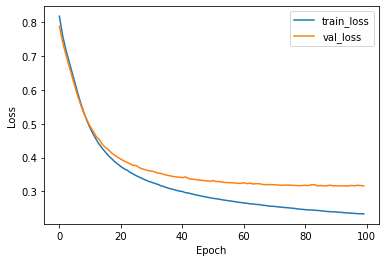

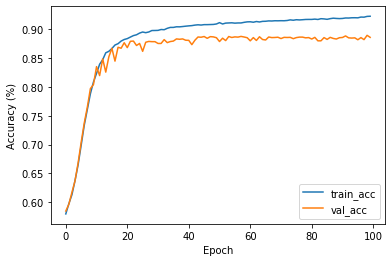

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.clf()

plt.plot(history.history['acc'], label='train_acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.clf()

# Evaluate

In [11]:
test_data, test_label = load_data('test')
test_label = np.array(test_label[:1000]).reshape(-1, 1)
test_data = normalize_data(test_data[:1000])
test_label[test_label == '\"'] = 0
test_label = test_label.astype('int')
test_label[test_label == '0'] = 0
test_label[test_label == '1'] = 1

test_sequences = tokenizer.texts_to_sequences(test_data)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_predict = model.predict(test_padded)
test_predict[test_predict >= 0.5] = 1
test_predict[test_predict < 0.5] = 0
print('Accuracy:', (test_label == test_predict).sum() / test_label.shape[0])

Accuracy: 0.886


<ipython-input-11-d7f42dffa92d>:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  test_label[test_label == '0'] = 0
<ipython-input-11-d7f42dffa92d>:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  test_label[test_label == '1'] = 1
